# Bert Base Multiligual Cased Notebook

In [15]:
import gc
import os
from dotenv import load_dotenv
from random import choices
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchinfo import summary
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from datasets import Dataset, concatenate_datasets
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from transformers import BertTokenizer

## Model Preparation

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "Z:/Programing_Space/DataSpell_Workspace/Research_FinMLP Competition/0. Source Data/"

In [17]:
load_dotenv()
HF_TOKEN = os.getenv("HF_TOKEN")

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', token=HF_TOKEN)
pretrained = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", token=HF_TOKEN).to(device)
summary(pretrained)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              91,812,096
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           1,538
Total params: 17

## Configuration for Layer Freezing

In [19]:
# for param in pretrained.parameters():
#     param.requires_grad = False

# for layer in pretrained.bert.encoder.layer[:6]:
#     for param in layer.parameters():
#         param.requires_grad = False

## Load & Process dataset

In [20]:
chn_dataset = pd.read_parquet(dataset_path+"train_df_Chinese_translated.parquet")
eng_dataset = pd.read_parquet(dataset_path+"train_df_English_translated.parquet")
fre_dataset = pd.read_parquet(dataset_path+"train_df_French_translated.parquet")
kor_dataset = pd.read_parquet(dataset_path+"train_df_Korean_translated.parquet")
del chn_dataset["sentence_ch"]
eng_dataset["Translation"] = eng_dataset["sentence"]
dataset = pd.concat([chn_dataset,eng_dataset,fre_dataset,kor_dataset])
dataset["sentence"] = dataset["Translation"]
del dataset["Translation"]
dataset.head(5)

,url,title,content,impact_length_idx,language,sentence
545,https://esg.businesstoday.com.tw/article/categ...,老闆本人就是打卡機？比爾蓋茲背下員工車牌，計算每人工作時數,日期：\n2022-01-04\n工作與生活的平衡在現代是所有員工流行且追求的工作模式，但對...,2.0,Chinese,The boss himself is a punch machine?Bill Gates...
546,https://esg.businesstoday.com.tw/article/categ...,Mercedes-Maybach也要電動化，全新賓士EQE、AMG首款電動車將齊聚慕尼黑車展！,日期：\n2021-09-06\n兩年前還稱作法蘭克福車展的IAA Mobility，在確定...,0.0,Chinese,Mercedes-Maybach also wants to be electrified....
547,https://esg.businesstoday.com.tw/article/categ...,銅板價吸引小資族、送電到你家，光陽掀電動機車霸主卡位戰！,日期：\n2021-08-18\n傳統機車龍頭光陽強勢壓境，企圖以﹁Ionex尊榮換電﹂服務...,0.0,Chinese,The price of copper board attracts petty bourg...
548,https://esg.businesstoday.com.tw/article/categ...,國際級節能減碳建築地標！陶朱隱園不只是豪宅，屋頂就裝了六台風力發電設備,日期：\n2021-11-03\n威京集團今(3)日公布全新的CIS(企業識別系統)，以藍天...,1.0,Chinese,International -level energy -saving carbon red...
549,https://esg.businesstoday.com.tw/article/categ...,台泥 Atlante Co. 獲歐盟基金挹注！建置 215 座歐洲純綠電儲能充電站,日期：\n2022-09-22\n台泥今日宣布子公司 NHOA 旗下專責發展電動車快充基礎設...,2.0,Chinese,TSM ATLANTE Co. was noted in the EU Fund!Build...


In [21]:
dataset["stratified_col"] = dataset["impact_length_idx"].astype(str) + dataset["language"] # for train/test split
dataset["resample_col"] = dataset["stratified_col"] # for resampling
esg_dataset = Dataset.from_pandas(dataset, preserve_index=True)

In [22]:
esg_dataset = esg_dataset.class_encode_column("impact_length_idx") # encode label
train_valid = esg_dataset.class_encode_column("stratified_col").train_test_split(test_size=0.25, stratify_by_column="stratified_col")
train_dataset = train_valid["train"]
valid_dataset = train_valid["test"]

Stringifying the column:   0%|          | 0/2358 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2358 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/2358 [00:00<?, ? examples/s]

In [23]:
train_idx = sorted(train_dataset['__index_level_0__'])
class_counts = dataset.loc[train_idx]['resample_col'].value_counts()
majority_class = class_counts.idxmax()
majority_count = class_counts.max()

def upsample(dataset, majority_class, majority_count):
    # upsample every class to the same size of majority class
    upsampled_datasets = []

    for class_label in set(dataset['resample_col']):
        class_dataset = dataset.filter(lambda x: x["resample_col"] == class_label)

        if majority_class == class_label:
            upsampled_datasets.append(class_dataset)
        else:
            upsampled = class_dataset.select(choices(range(len(class_dataset)), k=majority_count))
            upsampled_datasets.append(upsampled)

    return concatenate_datasets(upsampled_datasets)

resampled_train = upsample(train_dataset, majority_class,majority_count)

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1768 [00:00<?, ? examples/s]

In [24]:
def collate_fn(data):
    sentences = [i["sentence"] for i in data]
    labels = torch.tensor([i["impact_length_idx"] for i in data]).to(device)

    data = tokenizer.batch_encode_plus(sentences,
                                       truncation=True,
                                       padding='max_length',
                                       max_length=400,
                                       return_tensors='pt',
                                       return_length=True)

    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    token_type_ids = data['token_type_ids'].to(device)

    return input_ids, attention_mask, token_type_ids, labels

train_loader = torch.utils.data.DataLoader(dataset=resampled_train,
                                    batch_size=16,
                                    collate_fn=collate_fn,
                                    shuffle=True,
                                    drop_last=True)

loader_valid = torch.utils.data.DataLoader(dataset=valid_dataset,
                                            batch_size=16,
                                            collate_fn=collate_fn,
                                            shuffle=True,
                                            drop_last=True)

In [25]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(768, 384).to(device)
        self.fc2 = torch.nn.Linear(384, 192).to(device)
        self.fc3 = torch.nn.Linear(192, 3).to(device)
        self.dropout = torch.nn.Dropout(0.1)
        self.activation = torch.nn.LeakyReLU()
        # print(summary(self.fc))

    def forward(self, input_ids, attention_mask, token_type_ids):
        out = pretrained(input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    output_hidden_states=True)
        
        
        
        out = self.fc1(out["hidden_states"][-1][:, 0])
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)


        out = out.softmax(dim=1)

        return out

model = Model()

In [26]:
#5e^4, 0.01
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 3
optimizer = torch.optim.Adamax(model.parameters(),
                              lr=1e-4,
                              weight_decay=0.01)
# Total number of training steps
num_training_steps = num_epochs * len(train_loader)
# Scheduler including warm-up
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=num_training_steps * 0.1,
                                            num_training_steps=num_training_steps)

In [27]:
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        out = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids)
        
        gc.collect()

        loss = criterion(out, labels)
        loss.backward()
        
        gc.collect()

        
        optimizer.step()
        scheduler.step()
        

        if i % 25 == 0:
            out = out.argmax(dim=1)
            accuracy = (out == labels).sum().item() / len(labels)

            print(f"Epoch {epoch+1}/{num_epochs}, Step {i}, Loss: {loss.item()}, Accuracy: {accuracy}")
        
        gc.collect()

        
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        out = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids)

    out = out.argmax(dim=1)
    correct += (out == labels).sum().item()
    total += len(labels)
    accuracy = correct / total
    
    print("epoch valid accuracy:", accuracy)
    
    gc.collect()
        
    model.train()

Starting epoch 1/3
Epoch 1/3, Step 0, Loss: 1.0978553295135498, Accuracy: 0.375
Epoch 1/3, Step 25, Loss: 1.1043097972869873, Accuracy: 0.125
Epoch 1/3, Step 50, Loss: 1.1013280153274536, Accuracy: 0.25
Epoch 1/3, Step 75, Loss: 1.0931768417358398, Accuracy: 0.5
Epoch 1/3, Step 100, Loss: 1.0919073820114136, Accuracy: 0.5
Epoch 1/3, Step 125, Loss: 1.1010546684265137, Accuracy: 0.3125
Epoch 1/3, Step 150, Loss: 1.0973312854766846, Accuracy: 0.4375
Epoch 1/3, Step 175, Loss: 1.1009631156921387, Accuracy: 0.3125
Epoch 1/3, Step 200, Loss: 1.0965876579284668, Accuracy: 0.3125
Epoch 1/3, Step 225, Loss: 1.0973631143569946, Accuracy: 0.375
epoch valid accuracy: 0.3125
Starting epoch 2/3
Epoch 2/3, Step 0, Loss: 1.0911701917648315, Accuracy: 0.6875
Epoch 2/3, Step 25, Loss: 1.098168134689331, Accuracy: 0.25
Epoch 2/3, Step 50, Loss: 1.0941392183303833, Accuracy: 0.625
Epoch 2/3, Step 75, Loss: 1.0982029438018799, Accuracy: 0.25
Epoch 2/3, Step 100, Loss: 1.0999281406402588, Accuracy: 0.3125


Accuracy: 0.4635416666666667
Precision: 0.44685877387931877
Recall: 0.4209504059356675
F1 Score: 0.4060102198000426


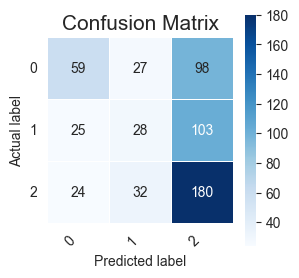

In [28]:
def test():
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    for i, (input_ids, attention_mask, token_type_ids, labels) in enumerate(loader_valid):

        with torch.no_grad():
            out = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)

        out = out.argmax(dim=1)
        correct += (out == labels).sum().item()
        total += len(labels)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(out.cpu().numpy())

    accuracy = correct / total
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt="0", linewidths=.5,
                square = True, cmap = "Blues")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.xticks(ticks=np.arange(3) + 0.5, labels=[0, 1, 2], rotation=45, ha='right')
    plt.yticks(ticks=np.arange(3) + 0.5, labels=[0, 1, 2], rotation=0)

    all_sample_title = "Confusion Matrix"
    plt.title(all_sample_title, size = 15)

test()